In [11]:
from collections import deque
# from graphviz import Digraph
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import sklearn as sk


In [12]:
class Node:
    def __init__(self, model_bundle=None, value=None):
        self.model_bundle = model_bundle
        self.value = value
        self.left = None
        self.right = None

class TreeDecision:
    def __init__(self):
        self.root = None

    def insert(self, data, model_bundle=None):
        if self.root is None:
            self.root = Node(model_bundle=model_bundle, value=data)
        else:
            self._insert_recursive(self.root, data, model_bundle)

    def _insert_recursive(self, current_node, data, model_bundle):
        if data < current_node.value: 
            if current_node.left is None:
                current_node.left = Node(model_bundle=model_bundle, value=data)
            else:
                self._insert_recursive(current_node.left, data, model_bundle)
        else:
            if current_node.right is None:
                current_node.right = Node(model_bundle=model_bundle, value=data)
            else:
                self._insert_recursive(current_node.right, data, model_bundle)
                
    def insert_leaf_model(self, model_bundle, value): 
        def _insert_leaf(node, mb, val):
            if val < node.value:
                if node.left is None:
                    node.left = Node(model_bundle=mb, value='<' + str(node.value)) 
                else:
                    _insert_leaf(node.left, mb, val)
            else:
                if node.right is None:
                    node.right = Node(model_bundle=mb, value='>=' + str(node.value)) 
                else:
                    _insert_leaf(node.right, mb, val)

        if self.root is not None: 
            _insert_leaf(self.root, model_bundle, value)
            
    def train_structure_decomposition(self,data_frame):
        features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
        MIN_SAMPLES_FOR_SVR_LEAF = 5 # Minimum samples to attempt SVR training

        def train_leaf_model(node, df):
            if node is None:
                return
                
            if node.left is None and node.right is None: # Leaf node
                if len(df) < MIN_SAMPLES_FOR_SVR_LEAF: # Check for minimum samples
                    node.model_bundle = None # Not enough data to train
                    return 
                
                X = df[features]
                y = df['total_sold']
                
                if X.empty or y.empty: # Should be caught by len(df) check already
                    node.model_bundle = None
                    return

                scaler_X = StandardScaler()
                scaler_y = StandardScaler()
                
                try:
                    X_scaled = scaler_X.fit_transform(X)
                    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()
                except ValueError: 
                    node.model_bundle = None 
                    return
                
                svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
                try:
                    svr_model.fit(X_scaled, y_scaled)
                    node.model_bundle = {
                        'model': svr_model,
                        'scaler_X': scaler_X,
                        'scaler_y': scaler_y
                    }
                except Exception: 
                    node.model_bundle = None
                return 
            
            # Internal node: split and continue
            try:
                threshold = float(node.value) 
                left_df = df[df['price_ori'] < threshold]
                right_df = df[df['price_ori'] >= threshold]
                train_leaf_model(node.left, left_df)
                train_leaf_model(node.right, right_df)
            except ValueError: 
                return

        if self.root is not None:
            train_leaf_model(self.root, data_frame) 
        
    def prediction(self,df_input): 
        predictions = []
        features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']

        def choosing_model(node,current_df_subset):
            if node is None or len(current_df_subset) == 0:
                return
                
            if node.left is None and node.right is None:
                # Leaf node: make predictions and store with index
                if node.model_bundle and node.model_bundle.get('model'):
                    svr_model = node.model_bundle['model']
                    scaler_X_leaf = node.model_bundle['scaler_X']
                    scaler_y_leaf = node.model_bundle['scaler_y']
                    
                    X_to_predict = current_df_subset[features] 
                    if X_to_predict.empty: # Should be caught by len(current_df_subset)
                        return

                    try:
                        X_to_predict_scaled = scaler_X_leaf.transform(X_to_predict)
                        y_pred_scaled = svr_model.predict(X_to_predict_scaled)
                        y_pred = scaler_y_leaf.inverse_transform(y_pred_scaled.reshape(-1, 1))
                        
                        result_df = pd.DataFrame({
                            'index': current_df_subset.index,
                            'prediction': y_pred.ravel() 
                        })
                        predictions.append(result_df)
                    except Exception: 
                        pass 
                return 

            # Internal node: split and continue
            try:
                threshold = float(node.value)
                left_df_subset = current_df_subset[current_df_subset['price_ori'] < threshold]
                right_df_subset = current_df_subset[current_df_subset['price_ori'] >= threshold]
                choosing_model(node.left, left_df_subset)
                choosing_model(node.right, right_df_subset)
            except ValueError: 
                return
                
        if self.root is not None:
            choosing_model(self.root, df_input) 
            
        if predictions:
            final_df = pd.concat(predictions).set_index('index').sort_index()
            return final_df
        else:
            return pd.DataFrame(columns=['prediction'])


In [13]:
TreeSVR=TreeDecision() 
df=pd.read_csv("fashion_data_set.csv") 

# Data cleaning for 'discount' feature
df['discount']=100*(1.-df['price_actual']/df['price_ori'])
df['discount'] = df['discount'].replace([np.inf, -np.inf], np.nan) # Replace inf with NaN first
df['discount'] = df['discount'].fillna(0) # Fill all NaNs (original and from inf) with 0

TreeSVR.insert(data=1000) 
TreeSVR.insert(data=500)
TreeSVR.insert(data=250)
TreeSVR.insert(data=150)
TreeSVR.insert(data=0) 
TreeSVR.insert(data=200)
TreeSVR.insert(data=150.1) 
TreeSVR.insert(data=249.9)
TreeSVR.insert(data=300)
TreeSVR.insert(data=250.1)
TreeSVR.insert(data=499.99)
TreeSVR.insert(data=999.9)
TreeSVR.insert(data=2500)
TreeSVR.insert(data=1500)
TreeSVR.insert(data=10000)
TreeSVR.insert(data=2499.9)
TreeSVR.insert(data=1000.1)

TreeSVR.train_structure_decomposition(data_frame=df)


In [14]:
features = ['price_ori', 'item_rating', 'price_actual', 'total_rating', 'favorite', 'discount']
X=df.loc[df['price_ori']<100,features]
y=df.loc[df['price_ori']<100,'total_sold']

# Basic check to ensure X and y are not empty before splitting
if not X.empty and not y.empty and len(X) > 1 and len(y) > 1: # train_test_split needs at least 2 samples
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.33) 
else: # Fallback if subset is too small or empty
    X_train, X_test, y_train, y_test = pd.DataFrame(columns=features), pd.DataFrame(columns=features), pd.Series(dtype='float64'), pd.Series(dtype='float64')

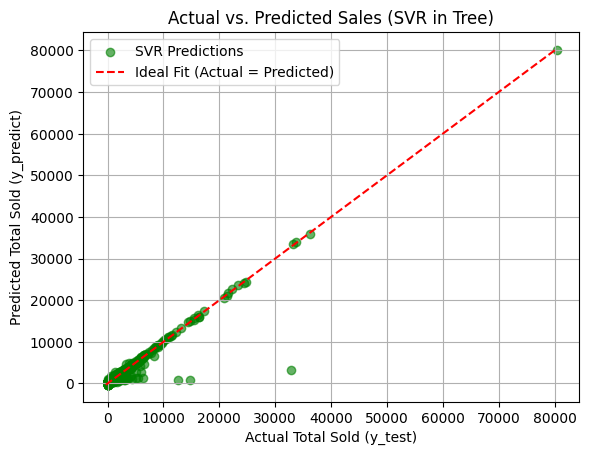

In [16]:
import matplotlib.pyplot as plt 

y_predict_df = TreeSVR.prediction(X_test) 

fig=plt.figure()

if not y_predict_df.empty and not y_test.empty:
    plot_data = pd.DataFrame({'y_test_plot': y_test.sort_index(), 
                              'y_predict_plot': y_predict_df['prediction']}).dropna()

    if not plot_data.empty: # Ensure plot_data is not empty after dropna
        # Add label to scatter plot
        plt.scatter(plot_data['y_test_plot'], plot_data['y_predict_plot'], color='green', alpha=0.6, label='SVR Predictions') 
        
        min_val = min(plot_data['y_test_plot'].min(), plot_data['y_predict_plot'].min()) 
        max_val = max(plot_data['y_test_plot'].max(), plot_data['y_predict_plot'].max())
        # Add label to the diagonal line
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (Actual = Predicted)') 
    else:
        # Still plot empty if plot_data becomes empty, but add labels for consistency if legend is called
        plt.scatter([],[],color='green', label='SVR Predictions')
        plt.plot([0,1],[0,1],color='red', linestyle='--', label='Ideal Fit (Actual = Predicted)')

else:
    plt.scatter([],[],color='green', label='SVR Predictions') 
    plt.plot([0,1],[0,1],color='red', linestyle='--', label='Ideal Fit (Actual = Predicted)')

plt.xlabel('Actual Total Sold (y_test)') 
plt.ylabel('Predicted Total Sold (y_predict)') 
plt.title('Actual vs. Predicted Sales (SVR in Tree)') 
plt.grid(True) 
plt.legend() # This is the crucial line to display the labels
plt.show()

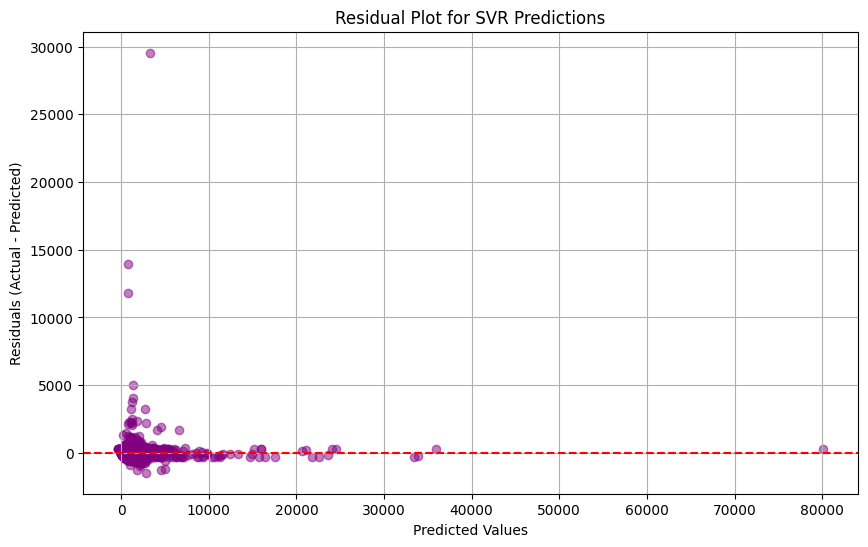

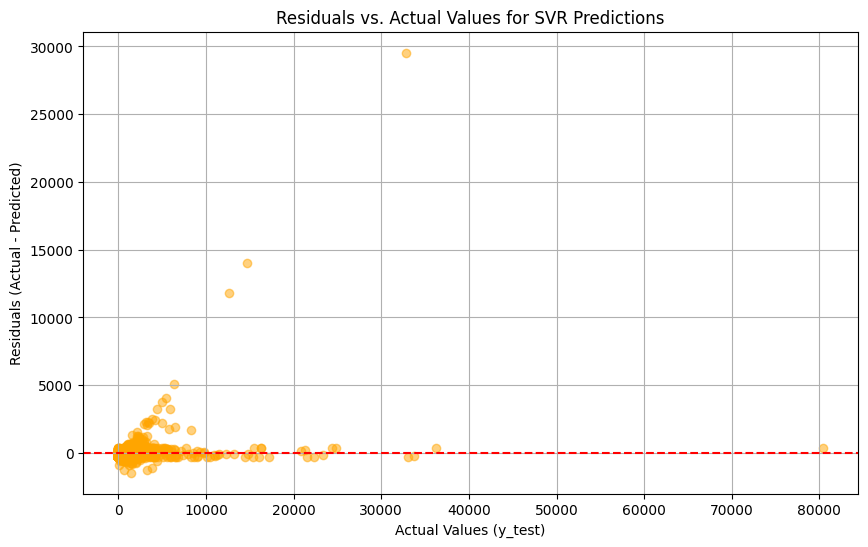

In [17]:
# Cell 6: Residual Plot

if not y_predict_df.empty and not y_test.empty and not plot_data.empty:
    # Calculate residuals using the aligned plot_data from Cell 5
    residuals = plot_data['y_test_plot'] - plot_data['y_predict_plot']
    
    plt.figure(figsize=(10, 6))
    plt.scatter(plot_data['y_predict_plot'], residuals, color='purple', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--') # Line at y=0 for reference
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title('Residual Plot for SVR Predictions')
    plt.grid(True)
    plt.show()
    
    # You can also plot residuals against actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(plot_data['y_test_plot'], residuals, color='orange', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Actual Values (y_test)')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title('Residuals vs. Actual Values for SVR Predictions')
    plt.grid(True)
    plt.show()
else:
    print("Cannot generate residual plot: Not enough data from previous predictions or actuals.")

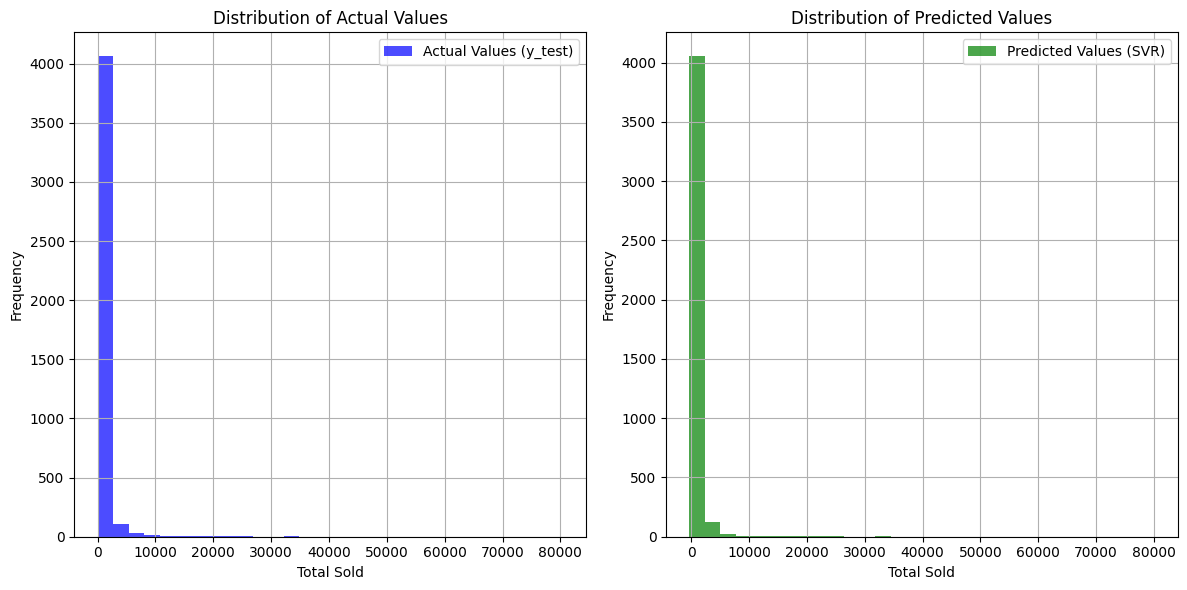

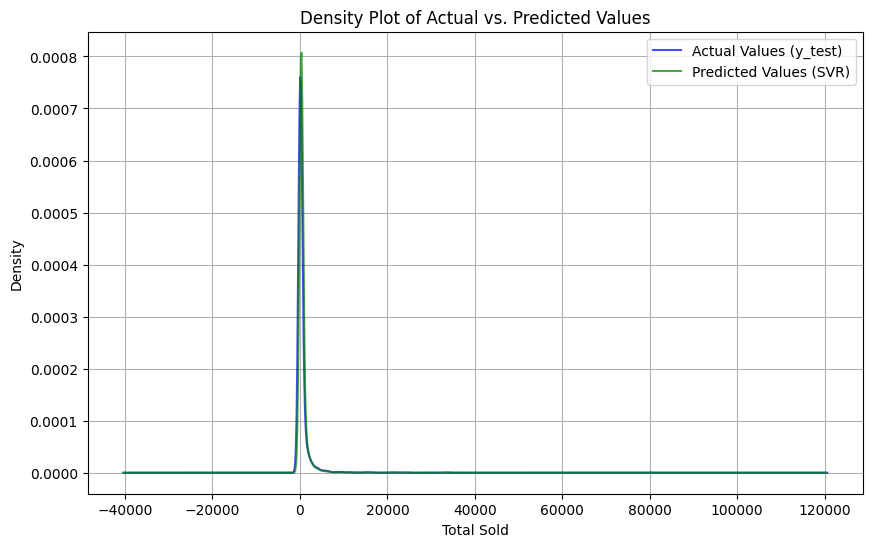

In [18]:
# Cell 7: Distribution of Predictions vs. Actuals

if not y_predict_df.empty and not y_test.empty and not plot_data.empty:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
    plt.hist(plot_data['y_test_plot'], bins=30, color='blue', alpha=0.7, label='Actual Values (y_test)')
    plt.xlabel('Total Sold')
    plt.ylabel('Frequency')
    plt.title('Distribution of Actual Values')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
    plt.hist(plot_data['y_predict_plot'], bins=30, color='green', alpha=0.7, label='Predicted Values (SVR)')
    plt.xlabel('Total Sold')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Values')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout() # Adjusts subplot params for a tight layout
    plt.show()
    
    # You can also overlay them using density plots for a different view
    plt.figure(figsize=(10,6))
    plot_data['y_test_plot'].plot(kind='density', color='blue', label='Actual Values (y_test)', alpha=0.7)
    plot_data['y_predict_plot'].plot(kind='density', color='green', label='Predicted Values (SVR)', alpha=0.7)
    plt.title('Density Plot of Actual vs. Predicted Values')
    plt.xlabel('Total Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Cannot generate distribution plots: Not enough data from previous predictions or actuals.")